In [5]:
!pip install scipy==1.9.0 gwcosmo numba==0.60.0

In [6]:
from gwcosmo import priors as p

identifier_dict = dict(
    mminbh=26,
    mmaxbh=125,
    alpha_1=6.75,
    alpha_2=0.0,
    b=0.5,
    delta_m=5,
    mminns=1.0,
    mmaxns=3.0,
    alphans=0.0,
)

model = p.NSBH_broken_powerlaw(
    mminbh=identifier_dict["mminbh"],
    mmaxbh=identifier_dict["mmaxbh"],
    alpha_1=identifier_dict["alpha_1"],
    alpha_2=identifier_dict["alpha_2"],
    b=identifier_dict["b"],
    delta_m=identifier_dict["delta_m"],
    mminns=identifier_dict["mminns"],
    mmaxns=identifier_dict["mmaxns"],
    alphans=identifier_dict["alphans"],
)
mass_1_, mass_2_ = model.sample(Nsample=20000)

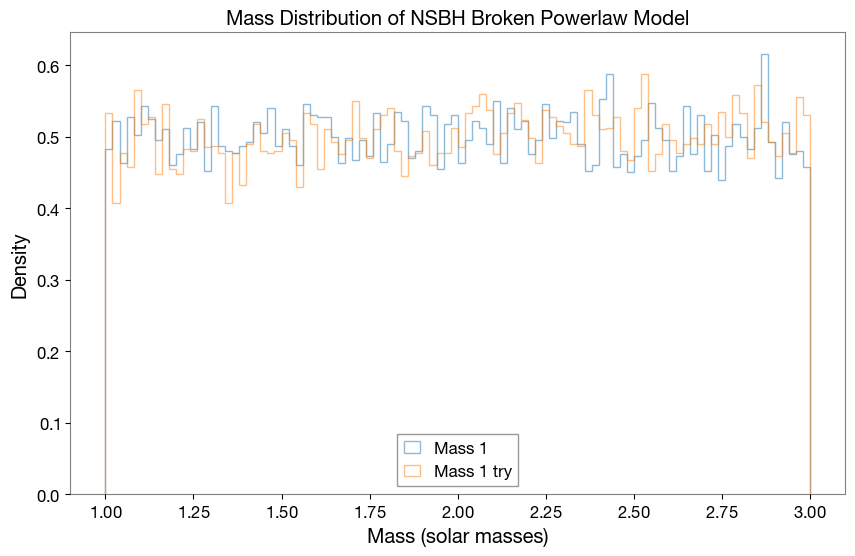

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(mass_2_, bins=100, density=True, alpha=0.5, label='Mass 1', histtype='step')
plt.hist(mass_2_new, bins=100, density=True, alpha=0.5, label='Mass 1 try', histtype='step')
#plt.hist(mass_2_, bins=100, density=True, alpha=0.5, label='Mass 2')
plt.xlabel('Mass (solar masses)')
plt.ylabel('Density')
plt.title('Mass Distribution of NSBH Broken Powerlaw Model')
plt.legend()
plt.grid()
plt.show()

In [69]:
#mminbh=26., mmaxbh=125., b=0.5
26. + 0.5 * (125. - 26.)  # mean of the broken powerlaw distribution

75.5

In [1]:
from ler.gw_source_population import sample_broken_powerlaw_nsbh_masses
import numpy as np

In [2]:
identifier_dict = dict(
    mminbh=26,
    mmaxbh=125,
    alpha_1=6.75,
    alpha_2=0.0,
    b=0.5,
    delta_m=5,
    mminns=1.0,
    mmaxns=3.0,
    alphans=0.0,
)

mass_1_new, mass_2_new = sample_broken_powerlaw_nsbh_masses(
    size=20000,
    mminbh=identifier_dict["mminbh"],
    mmaxbh=identifier_dict["mmaxbh"],
    alpha_1=identifier_dict["alpha_1"],
    alpha_2=identifier_dict["alpha_2"],
    b=identifier_dict["b"],
    delta_m=identifier_dict["delta_m"],
    mminns=identifier_dict["mminns"],
    mmaxns=identifier_dict["mmaxns"],
    alphans=identifier_dict["alphans"],
)

In [4]:
mass_1_new

array([33.26366776, 29.84945348, 54.33066679, ..., 28.93148332,
       28.27156589, 41.71570049])

In [ ]:
import numpy as np
from numba import njit
from scipy.integrate import quad # cumulative_trapezoid

@njit
def cumulative_trapezoid(y, x=None, dx=1.0, initial=0.0):
    """
    Compute the cumulative integral of a function using the trapezoidal rule.
    """
    if x is None:
        x = np.arange(len(y)) * dx

    # Calculate the cumulative integral using trapezoidal rule
    cumsum = np.zeros_like(y)
    cumsum[0] = initial
    for i in range(1, len(y)):
        cumsum[i] = cumsum[i - 1] + (y[i - 1] + y[i]) * (x[i] - x[i - 1]) / 2.0

    return cumsum

@njit
def smoothing_S(m, mmin, delta_m, threshold=709.0):
    s = np.zeros_like(m)

    # Region where smoothing is not needed: m >= mmin + delta_m
    idx_2 = m >= mmin + delta_m
    s[idx_2] = 1.0

    # Region where smoothing is applied: mmin <= m < mmin + delta_m
    idx_1 = (m >= mmin) & (m < mmin + delta_m)
    mprime = m[idx_1] - mmin
    exponent = delta_m / mprime + delta_m / (mprime - delta_m)

    # Safe exponentiation only where the exponent is below threshold
    safe_idx = exponent <= threshold
    s_vals = np.zeros_like(mprime)
    s_vals[safe_idx] = 1.0 / (np.exp(exponent[safe_idx]) + 1.0)

    # Assign back to main array
    s[idx_1] = s_vals

    return s

@njit
def powerlaw_with_smoothing(m, mmin, alpha, delta_m):
    """
    Power law with smoothing applied.
    """
    s = smoothing_S(m, mmin, delta_m)
    return m ** (-alpha) * s

@njit
def inverse_transform_sampler(size, cdf, x):
    """
    Function to sample from the inverse transform method.
    """

    u = np.random.uniform(0, 1, size)
    idx = np.searchsorted(cdf, u)
    x1, x0, y1, y0 = cdf[idx], cdf[idx-1], x[idx], x[idx-1]
    samples = y0 + (y1 - y0) * (u - x0) / (x1 - x0)
    return samples

@njit
def broken_powerlaw_cdf(size=1000, mminbh=26,mmaxbh=125,alpha_1=6.75,alpha_2=0.0,b=0.5,delta_m=5,mminns=1.0,mmaxns=3.0,alphans=0.0):

    # find normalization
    m_try = np.linspace(mminbh, mmaxbh, size)
    pdf_unnormalized = broken_powerlaw_unormalized(m_try, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5.)
    # Normalize the PDF
    cdf_values = cumulative_trapezoid(pdf_unnormalized, m_try, initial=0)
    normalization = cdf_values[size-1]
    # Normalize the CDF
    cdf_values /= normalization

    return cdf_values

@njit
def sample_broken_powerlaw(size=1000, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5., normalization_size=1000):
    """
    Generates samples from the broken powerlaw distribution.
    """
    # Generate the CDF
    #if cdf_values is None:
    cdf_values = broken_powerlaw_cdf(size=normalization_size, mminbh=mminbh, mmaxbh=mmaxbh, alpha_1=alpha_1, alpha_2=alpha_2, b=b, delta_m=delta_m)

    x = np.linspace(mminbh, mmaxbh, normalization_size)
    idx = np.argwhere(cdf_values > 0)[0][0]
    cdf_values = cdf_values[idx:]
    x = x[idx:]
    samples = inverse_transform_sampler(size, cdf_values, x)

    return samples

@njit
def broken_powerlaw_pdf(m, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5., normalization_size=1000):
    """
    Generates samples using a Numba-jitted loop for high performance.
    """
    # find normalization
    m_try = np.linspace(mminbh, mmaxbh, normalization_size)
    pdf_unnormalized = broken_powerlaw_unormalized(m_try, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5.)
    # Normalize the PDF
    normalization = np.trapz(pdf_unnormalized, m_try)

    # Generate the PDF for the input mass array
    pdf_unnormalized = broken_powerlaw_unormalized(m, mminbh=mminbh, mmaxbh=mmaxbh, alpha_1=alpha_1, alpha_2=alpha_2, b=b, delta_m=delta_m)
    # Normalize the PDF
    pdf = pdf_unnormalized / normalization

    return pdf

@njit
def broken_powerlaw_unormalized(m, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5.):
    """
    Probability density function for the broken powerlaw model.
    """
    mbreak = mminbh + b * (mmaxbh - mminbh)
    idx_1 = (m > mminbh) & (m < mbreak)
    idx_2 = (m >= mbreak) & (m < mmaxbh)

    pdf_unnormalized = np.zeros_like(m)
    pdf_unnormalized[idx_1] = powerlaw_with_smoothing(m[idx_1], mminbh, alpha_1, delta_m) # m[idx_1] ** (-alpha_1) * smoothing_S(m[idx_1], mminbh, delta_m)
    norm_1 = pdf_unnormalized[idx_1][np.sum(idx_1)-1]
    pdf_unnormalized[idx_2] = powerlaw_with_smoothing(m[idx_2], mminbh, alpha_2, delta_m)
     # (m[idx_2] ** (-alpha_2)* smoothing_S(m[idx_2], mminbh, delta_m))
    norm_2 = pdf_unnormalized[idx_2][0]
    pdf_unnormalized[idx_2] = pdf_unnormalized[idx_2] * (norm_1 / norm_2)
    
    return pdf_unnormalized

# # --- Parameters ---
# identifier_dict = dict(
#     mminbh=26,
#     mmaxbh=125,
#     alpha_1=6.75,
#     alpha_2=0.0,
#     b=0.5,
#     delta_m=5,
#     mminns=1.0,
#     mmaxns=3.0,
#     alphans=0.0,
# )
# m1 = np.linspace(identifier_dict["mminbh"], identifier_dict["mmaxbh"], 1000)
# pdf = broken_powerlaw_pdf(
#     m=m1,
#     mminbh=identifier_dict["mminbh"],
#     mmaxbh=identifier_dict["mmaxbh"],
#     alpha_1=identifier_dict["alpha_1"],
#     alpha_2=identifier_dict["alpha_2"],
#     b=identifier_dict["b"],
#     delta_m=identifier_dict["delta_m"],
#     normalization_size=1000
# )

In [30]:
# with parallel=True; time=2.41 ms
# without parallel=True; time=577 mu s
%timeit m1_sample = sample_broken_powerlaw(10000)

2.43 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
test = np.array([1,1,0,0,0], dtype=bool)
test2 = np.array([1,0,0,0,0])
test2[test][np.sum(test)-1]

0

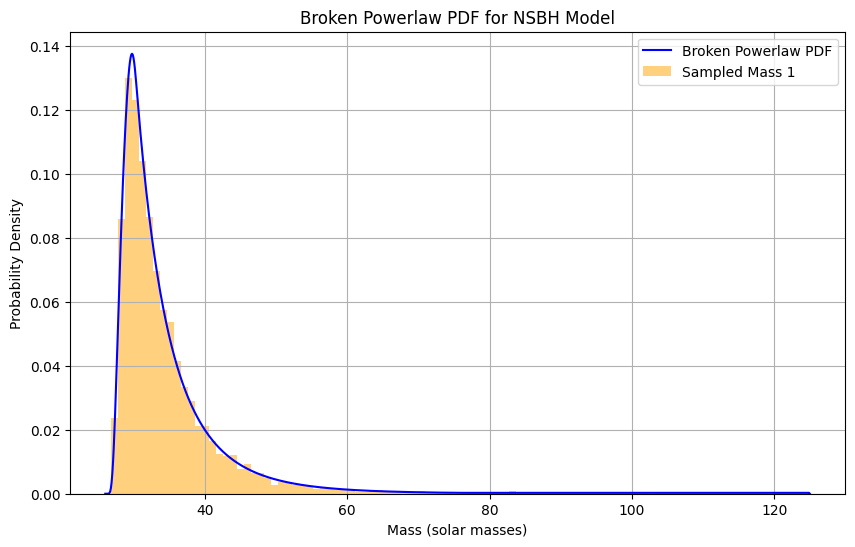

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(m1, pdf, label='Broken Powerlaw PDF', color='blue')
plt.hist(m1_sample, bins=100, density=True, alpha=0.5, label='Sampled Mass 1', color='orange')
plt.xlabel('Mass (solar masses)')
plt.ylabel('Probability Density')
plt.title('Broken Powerlaw PDF for NSBH Model')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
from numba import njit

@njit
def cumulative_trapezoid(y, x, initial=0.0):
    """
    Cumulative integral using trapezoidal rule, fully Numba-optimized.
    Assumes x is a strictly increasing array of same length as y.
    """
    n = len(y)
    cumsum = np.empty(n, dtype=np.float64)
    cumsum[0] = initial
    for i in range(1, n):
        dx = x[i] - x[i-1]
        cumsum[i] = cumsum[i-1] + 0.5 * (y[i] + y[i-1]) * dx
    return cumsum

@njit
def smoothing_S(m, mmin, delta_m, threshold=709.0):
    """
    Vectorized smoothing window for low-mass cutoff.
    """
    s = np.zeros_like(m)
    for i in range(len(m)):
        if m[i] >= mmin + delta_m:
            s[i] = 1.0
        elif m[i] > mmin:
            mprime = m[i] - mmin
            exponent = delta_m / mprime + delta_m / (mprime - delta_m)
            if exponent <= threshold:
                s[i] = 1.0 / (np.exp(exponent) + 1.0)
    return s

@njit
def powerlaw_with_smoothing(m, mmin, alpha, delta_m):
    """
    Power law with smoothing (elementwise).
    """
    return m ** (-alpha) * smoothing_S(m, mmin, delta_m)

@njit
def broken_powerlaw_unormalized(m, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m):
    """
    Unnormalized broken power law PDF (Numba, optimized).
    """
    mbreak = mminbh + b * (mmaxbh - mminbh)
    pdf = np.zeros_like(m)
    for i in range(len(m)):
        if m[i] > mminbh and m[i] < mbreak:
            pdf[i] = powerlaw_with_smoothing(np.array([m[i]]), mminbh, alpha_1, delta_m)[0]
        elif m[i] > mbreak and m[i] < mmaxbh:
            pdf[i] = powerlaw_with_smoothing(np.array([m[i]]), mminbh, alpha_2, delta_m)[0]
    # Optional: force continuity at mbreak, or normalize branches separately if needed.
    return pdf

@njit
def broken_powerlaw_pdf(m, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5., normalization_size=1000):
    """
    Normalized PDF for broken power law (Numba, optimized).
    """
    m_grid = np.linspace(mminbh, mmaxbh, normalization_size)
    pdf_grid = broken_powerlaw_unormalized(m_grid, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m)
    normalization = np.trapz(pdf_grid, m_grid)
    pdf = broken_powerlaw_unormalized(m, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m)
    return pdf / normalization

@njit
def broken_powerlaw_cdf(m_grid, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m):
    """
    CDF (Numba, optimized), evaluated on a grid.
    """
    pdf_grid = broken_powerlaw_unormalized(m_grid, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m)
    cdf_grid = cumulative_trapezoid(pdf_grid, m_grid, initial=0.0)
    normalization = cdf_grid[-1]
    return cdf_grid / normalization

@njit
def inverse_transform_sampler(size, cdf, x):
    """
    Inverse CDF sampler (Numba, optimized).
    """
    samples = np.empty(size)
    for i in range(size):
        u = np.random.rand()
        idx = np.searchsorted(cdf, u)
        if idx == 0:
            samples[i] = x[0]
        elif idx >= len(x):
            samples[i] = x[-1]
        else:
            x1, x0, y1, y0 = cdf[idx], cdf[idx-1], x[idx], x[idx-1]
            # Linear interpolation
            samples[i] = y0 + (y1 - y0) * (u - x0) / (x1 - x0)
    return samples

@njit
def sample_broken_powerlaw(size=1000, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5., normalization_size=1000):
    """
    Public sampler (not Numba due to array allocations).
    """
    m_grid = np.linspace(mminbh, mmaxbh, normalization_size)
    cdf_grid = broken_powerlaw_cdf(m_grid, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m)
    # Only use the region where cdf strictly increases:
    good = cdf_grid > 0
    m_grid = m_grid[good]
    cdf_grid = cdf_grid[good]
    return inverse_transform_sampler(size, cdf_grid, m_grid)



In [139]:
m1_sample = sample_broken_powerlaw(10000)

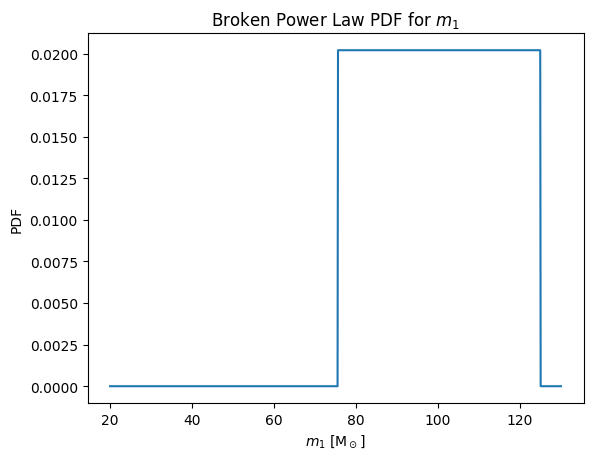

In [ ]:
import numpy as np

def smoothing_S(m, mmin, delta_m, threshold=709.0):
    """
    Smoothing function for the low-mass cutoff, vectorized for array input.
    S(m) transitions smoothly from 0 to 1 between mmin and mmin + delta_m.

    Parameters:
    -----------
    m : float or np.ndarray
        Mass value(s) at which to compute the smoothing function.
    mmin : float
        Minimum mass.
    delta_m : float
        Smoothing scale.
    threshold : float, optional
        Maximum allowed exponent to prevent overflow (default 709.0).

    Returns:
    --------
    s : float or np.ndarray
        Value(s) of the smoothing function at m.
    """
    m = np.atleast_1d(m)
    s = np.zeros_like(m, dtype=float)

    # Region where smoothing is not needed: m >= mmin + delta_m
    idx_smooth = m >= mmin + delta_m
    s[idx_smooth] = 1.0

    # Region where smoothing is applied: mmin < m < mmin + delta_m
    idx_window = (m > mmin) & (m < mmin + delta_m)
    mprime = m[idx_window] - mmin
    exponent = delta_m / mprime + delta_m / (mprime - delta_m)

    # Safe exponentiation only where exponent is below threshold
    safe = exponent <= threshold
    s_vals = np.zeros_like(mprime)
    s_vals[safe] = 1.0 / (np.exp(exponent[safe]) + 1.0)
    # Values where exponent > threshold remain 0 (safe default)
    s[idx_window] = s_vals

    # For scalar input, return scalar
    return s if s.shape != () else s.item()

def broken_powerlaw_unormalized(
    m, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5.):
    """
    Unnormalized probability density function for the broken power law.

    Parameters:
    -----------
    m : float or np.ndarray
        Mass value(s) to evaluate the PDF at.
    mminbh, mmaxbh : float
        Minimum and maximum mass for the BH component.
    alpha_1, alpha_2 : float
        Power-law indices below and above the break.
    b : float
        Fractional location of the break between min and max mass.
    delta_m : float
        Smoothing scale for the low-mass cutoff.

    Returns:
    --------
    pdf_unnormalized : float or np.ndarray
        Unnormalized PDF value(s) at m.
    """
    m = np.atleast_1d(m)
    mbreak = mminbh + b * (mmaxbh - mminbh)
    pdf_unnormalized = np.zeros_like(m, dtype=float)

    # Below break: mmin < m < mbreak
    idx1 = (m > mminbh) & (m < mbreak)
    pdf_unnormalized[idx1] = (
        m[idx1] ** (-alpha_1) * smoothing_S(m[idx1], mminbh, delta_m)
    )
    # Above break: mbreak < m < mmax
    idx2 = (m > mbreak) & (m < mmaxbh)
    pdf_unnormalized[idx2] = (
        m[idx2] ** (-alpha_2) * smoothing_S(m[idx2], mminbh, delta_m)
    )
    # Outside: remains zero

    return pdf_unnormalized if pdf_unnormalized.shape != () else pdf_unnormalized.item()

def broken_powerlaw_pdf(
    m, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5., size=10000
):
    """
    Normalized PDF for the broken power law.

    Parameters:
    -----------
    m : float or np.ndarray
        Mass value(s) to evaluate the PDF at.
    Other parameters: as above.
    size : int
        Number of grid points for normalization.

    Returns:
    --------
    pdf : float or np.ndarray
        Normalized PDF value(s) at m.
    """
    m = np.atleast_1d(m)
    # Compute normalization over allowed mass range
    m_grid = np.linspace(mminbh, mmaxbh, size)
    pdf_unnorm = broken_powerlaw_unormalized(m_grid, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m)
    normalization = np.trapz(pdf_unnorm, m_grid)

    pdf_unnorm = broken_powerlaw_unormalized(m, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m)
    pdf = pdf_unnorm / normalization
    return pdf if pdf.shape != () else pdf.item()

# ---- Optional: Sampling function ----
def sample_broken_powerlaw(
    N, mminbh=26., mmaxbh=125., alpha_1=6.75, alpha_2=0., b=0.5, delta_m=5., size=10000
):
    """
    Draw N samples from the normalized broken power law PDF (inverse transform sampling).
    """
    m_grid = np.linspace(mminbh, mmaxbh, size)
    pdf = broken_powerlaw_pdf(m_grid, mminbh, mmaxbh, alpha_1, alpha_2, b, delta_m, size)
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    u = np.random.rand(N)
    samples = np.interp(u, cdf, m_grid)
    return samples

# ---- Example usage ----
if __name__ == '__main__':
    # Example: plot the normalized PDF
    import matplotlib.pyplot as plt
    m = np.linspace(20, 130, 1000)
    pdf = broken_powerlaw_pdf(m)
    plt.plot(m, pdf)
    plt.xlabel('$m_1$ [M$_\\odot$]')
    plt.ylabel('PDF')
    plt.title('Broken Power Law PDF for $m_1$')
    plt.show()


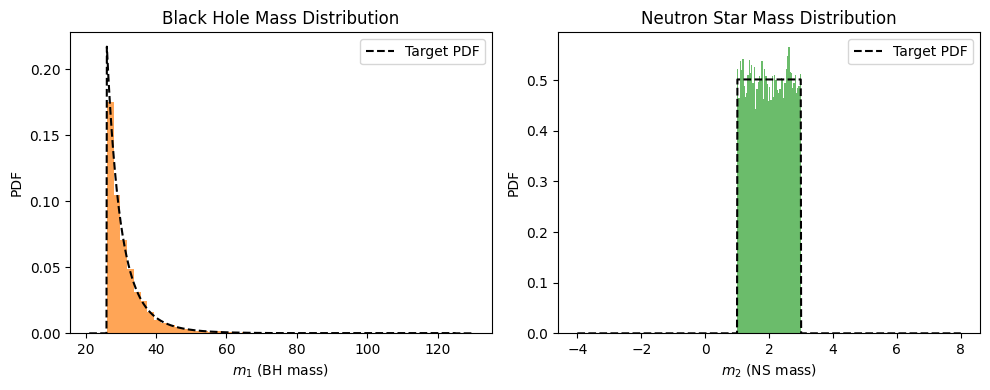

In [8]:
# Plotting
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(m1_samps, bins=50, density=True, alpha=0.7, color='C1')
m1_grid = np.linspace(mminbh - delta_m, mmaxbh + delta_m, 1000)
plt.plot(m1_grid, p_m1(m1_grid)/np.trapz(p_m1(m1_grid), m1_grid), 'k--', label='Target PDF')
plt.xlabel('$m_1$ (BH mass)')
plt.ylabel('PDF')
plt.title('Black Hole Mass Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(m2_samps, bins=50, density=True, alpha=0.7, color='C2')
m2_grid = np.linspace(mminns - delta_m, mmaxns + delta_m, 1000)
plt.plot(m2_grid, p_m2(m2_grid)/np.trapz(p_m2(m2_grid), m2_grid), 'k--', label='Target PDF')
plt.xlabel('$m_2$ (NS mass)')
plt.ylabel('PDF')
plt.title('Neutron Star Mass Distribution')
plt.legend()

plt.tight_layout()
plt.show()


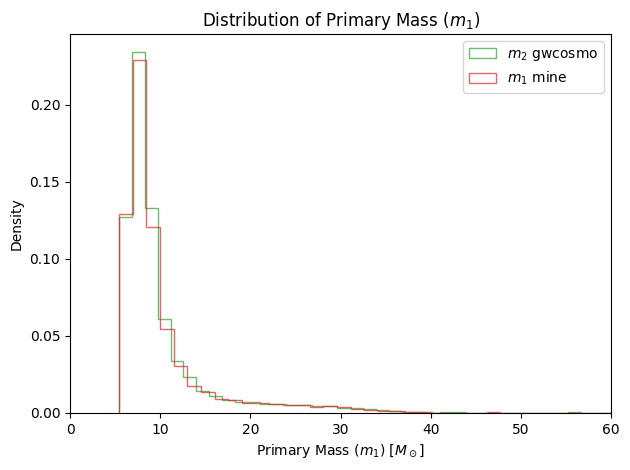

In [84]:
import matplotlib.pyplot as plt

# plt.hist(mass_1_, bins=60, density=True, alpha=0.7, color='C0', histtype='step', label=r'$m_1 gwcosmo$')
# plt.hist(m1_sample, bins=60, density=True, alpha=0.7, color='C1', histtype='step', label=r'$m_1 mine$')
plt.hist(mass_2_, bins=50, density=True, alpha=0.7, color='C2', histtype='step', label=r'$m_2$ gwcosmo')
plt.hist(m2_sample, bins=60, density=True, alpha=0.7, color='C3', histtype='step', label=r'$m_1$ mine')

plt.xlabel('Primary Mass ($m_1$) [$M_\\odot$]')
plt.ylabel('Density')
plt.xlim(0,60)
plt.title('Distribution of Primary Mass ($m_1$)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
import numpy as np
from numba import njit

@njit
def smoothing_S_numba(m, mmin, delta_m):
    """
    A Numba-jitted smoothing function for the low-mass cutoff.
    """
    if m < mmin:
        return 0.0
    elif m < mmin + delta_m:
        mprime = m - mmin
        # This calculation is safe from division by zero due to the checks above
        exponent = delta_m / mprime + delta_m / (mprime - delta_m)
        
        # Prevent overflow warning, as learned from the previous step
        if exponent > 709.0:
            return 0.0
            
        f = np.exp(exponent)
        return 1.0 / (f + 1.0)
    else:
        return 1.0

@njit
def generate_samples_numba(N_samples, mminbh, mmaxbh, alpha, mu_g, sigma_g, lambda_peak, delta_m, beta):
    """
    Generates samples using a Numba-jitted loop for high performance.
    """
    # Pre-allocate NumPy arrays to store the results. This is much faster
    # than appending to a list in a loop.
    m1_sample = np.empty(N_samples, dtype=np.float64)
    m2_sample = np.empty(N_samples, dtype=np.float64)
    
    accepted_count = 0
    
    # Pre-calculate powers outside the loop
    pow_alpha = 1.0 - alpha
    mmin_pow_alpha = mminbh**pow_alpha
    mmax_pow_alpha = mmaxbh**pow_alpha
    pow_beta = beta + 1.0
    
    # Use a 'while' loop to ensure we collect exactly N_samples,
    # accounting for samples rejected by the smoothing function.
    while accepted_count < N_samples:
        # 1. Sample m1
        # ----------------
        if np.random.rand() < lambda_peak:
            # Sample from Gaussian component
            m1_ = np.random.normal(mu_g, sigma_g) 
        else:
            # Sample from Power-law component
            # FIX: The original code was missing this random number draw
            u_pl = np.random.rand() 
            m1_ = (u_pl * (mmax_pow_alpha - mmin_pow_alpha) + mmin_pow_alpha)**(1.0 / pow_alpha)

        # 2. Apply smoothing rejection sampling for m1 and m2
        # ----------------------------------------------------
        # Draw a single random number for the joint smoothing check
        u_smooth = np.random.rand()
        
        s1 = smoothing_S_numba(m1_, mminbh, delta_m)
        if u_smooth > s1:
            continue  # Reject m1 and restart the loop

        # If m1 is accepted, sample m2
        qmin = mminbh / m1_
        
        # Rejection sampling loop for m2
        while True:
            u_q = np.random.rand()
            # Inverse transform sampling for mass ratio q
            q = (u_q * (1.0**pow_beta - qmin**pow_beta) + qmin**pow_beta)**(1.0 / pow_beta)
            m2_ = m1_ * q
            
            s_m2 = smoothing_S_numba(m2_, mminbh, delta_m)
            
            # The acceptance of m2 depends on the same random number 'u_smooth'.
            # This logic is preserved from the original code.
            u_smooth = np.random.rand()
            if u_smooth <= s_m2:
                break  # m2 is accepted, break the inner loop
        
        # 3. Store the accepted sample
        # -----------------------------
        m1_sample[accepted_count] = m1_
        m2_sample[accepted_count] = m2_
        accepted_count += 1
            
    return m1_sample, m2_sample

# --- Parameters ---
params = dict(
    mminbh=4.98,
    mmaxbh=112.5,
    alpha=3.78,
    mu_g=32.27,
    sigma_g=3.88,
    lambda_peak=0.03,
    delta_m=4.8,
    beta=0.81,
)

N_samples = 20000

m1_sample, m2_sample = generate_samples_numba(
    N_samples,
    params['mminbh'],
    params['mmaxbh'],
    params['alpha'],
    params['mu_g'],
    params['sigma_g'],
    params['lambda_peak'],
    params['delta_m'],
    params['beta']
)


In [56]:
import numpy as np
from numba import njit

@njit
def smoothing_S_numba(m, mmin, delta_m):
    """
    A Numba-jitted smoothing function for the low-mass cutoff.
    """
    if m < mmin:
        return 0.0
    elif m < mmin + delta_m:
        mprime = m - mmin
        # This calculation is safe from division by zero due to the checks above
        exponent = delta_m / mprime + delta_m / (mprime - delta_m)
        
        # Prevent overflow warning, as learned from the previous step
        if exponent > 709.0:
            return 0.0
            
        f = np.exp(exponent)
        return 1.0 / (f + 1.0)
    else:
        return 1.0

@njit
def generate_samples_numba(N_samples, mminbh, mmaxbh, alpha, mu_g, sigma_g, lambda_peak, delta_m, beta):
    """
    Generates samples using a Numba-jitted loop for high performance.
    """
    # Pre-allocate NumPy arrays to store the results. This is much faster
    # than appending to a list in a loop.
    m1_sample = np.empty(N_samples, dtype=np.float64)
    m2_sample = np.empty(N_samples, dtype=np.float64)
    
    accepted_count = 0
    
    # Pre-calculate powers outside the loop
    pow_alpha = 1.0 - alpha
    mmin_pow_alpha = mminbh**pow_alpha
    mmax_pow_alpha = mmaxbh**pow_alpha
    pow_beta = beta + 1.0
    
    # Use a 'while' loop to ensure we collect exactly N_samples,
    # accounting for samples rejected by the smoothing function.
    while accepted_count < N_samples:
        # 1. Sample m1
        # ----------------
        if np.random.rand() < lambda_peak:
            # Sample from Gaussian component
            m1_ = np.random.normal(mu_g, sigma_g) 
        else:
            # Sample from Power-law component
            # FIX: The original code was missing this random number draw
            u_pl = np.random.rand() 
            m1_ = (u_pl * (mmax_pow_alpha - mmin_pow_alpha) + mmin_pow_alpha)**(1.0 / pow_alpha)

        # 2. Apply smoothing rejection sampling for m1 and m2
        # ----------------------------------------------------
        # Draw a single random number for the joint smoothing check
        u_smooth = np.random.rand()
        
        s1 = smoothing_S_numba(m1_, mminbh, delta_m)
        if u_smooth > s1:
            continue  # Reject m1 and restart the loop

        # If m1 is accepted, sample m2
        qmin = mminbh / m1_
        
        # Rejection sampling loop for m2
        while True:
            u_q = np.random.rand()
            # Inverse transform sampling for mass ratio q
            q = (u_q * (1.0**pow_beta - qmin**pow_beta) + qmin**pow_beta)**(1.0 / pow_beta)
            m2_ = m1_ * q
            
            s_m2 = smoothing_S_numba(m2_, mminbh, delta_m)
            
            # The acceptance of m2 depends on the same random number 'u_smooth'.
            # This logic is preserved from the original code.
            if u_smooth <= s_m2:
                break  # m2 is accepted, break the inner loop
        
        # 3. Store the accepted sample
        # -----------------------------
        m1_sample[accepted_count] = m1_
        m2_sample[accepted_count] = m2_
        accepted_count += 1
            
    return m1_sample, m2_sample

# --- Parameters ---
params = dict(
    mminbh=4.98,
    mmaxbh=112.5,
    alpha=3.78,
    mu_g=32.27,
    sigma_g=3.88,
    lambda_peak=0.03,
    delta_m=4.8,
    beta=0.81,
)

N_samples = 20000

m1_sample, m2_sample = generate_samples_numba(
    N_samples,
    params['mminbh'],
    params['mmaxbh'],
    params['alpha'],
    params['mu_g'],
    params['sigma_g'],
    params['lambda_peak'],
    params['delta_m'],
    params['beta']
)


In [57]:
N_samples = 50000

%timeit m1_sample, m2_sample = generate_samples_numba(N_samples,params['mminbh'],params['mmaxbh'],params['alpha'],params['mu_g'],params['sigma_g'],params['lambda_peak'],params['delta_m'],params['beta'])

22.6 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
%timeit  mass_1_, mass_2_ = model.sample(Nsample=50000)

11 ms ± 23.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
# call the LeR class
from ler.rates import LeR

Setting multiprocessing start method to 'fork'


ImportError: cannot import name 'cumtrapz' from 'scipy.integrate' (/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnr/lib/python3.10/site-packages/scipy/integrate/__init__.py)

* You can check for more details on `LeR` class from either the [documentation](https://ler.readthedocs.io/en/latest/) or by calling `help(LeR)` or `LeR?` (in the Jupyter Notebook).

* Depending on the number of CPU cores used and microprocessor architecture, `LeR` class initialization will take some time to generate interpolation data for the models. Please be patient. e.g. it takes 1m 56s for 4 cores in M2 pro Aplle intel chip 16GB RAM.

* The generated interpolation data is saved and will be call automatically when the same model is used again. If user wants to regenerate the interpolation data, please set `create_new_interpolator=True` in the `LeR` class initialization. Or you can simply delete the `interpolator_json` directory or specific path in the `interpolator_json` directory.
  
* if you don't want the models and its parameters to print. Default is True.

    ```ler = LeR(verbose=False)```
    
* set 'npool' according to your machine's available CPU cores. Default is 4.
* to check no. of cores, 

    ```
    import multiprocessing as mp
    print(mp.cpu_count())
    ```

In [2]:
# LeR initialization with default arguments
ler = LeR()


Initializing LeR class...


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

using lens_redshift_strongly_lensed_mp
comoving_distance interpolator will be loaded from ./interpolator_json/comoving_distance/comoving_distance_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.pickle
Interpolated cross section function loaded from ./interpolator_json/cross_section_function/cross_section_function_0.pickle
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_ewoud_0.pickle
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_rayleigh interpolator will be l

### Simulation of the GW CBC population (unlensed). <a class="anchor" id="bullet-one-one"></a>

* this will generate a json file with the simulated population parameters.
  
* by default 100,000 events will be sampled with batches of 50,000. For more realistic results, keep batch_size=50000 and size>=1000000.
  
* results will be saved in the same directory as json file.
  
* `resume=True` will resume the simulation from the last saved batch.
  
* if you dont't need to save the file at the end of each batch sampling, set `save_batch=False` (default).

In [3]:
# ler.batch_size = 100000 # for faster computation
unlensed_param = ler.unlensed_cbc_statistics(size=100000, resume=False, save_batch=False)

unlensed params will be store in ./ler_data/unlensed_param.json
chosen batch size = 50000 with total size = 100000
There will be 2 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/phurailatpamhemantakumar/anaconda3/envs/ler/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
Batch no. 2
sampling gw source params...
calculating snrs...
saving all unlensed parameters in ./ler_data/unlensed_param.json 


### Calculation of unlensed rates. <a class="anchor" id="bullet-one-two"></a> 

In [9]:
rate_unlensed, unlensed_param_detectable = ler.unlensed_rate()

Getting unlensed_param from json file ./ler_data/unlensed_param.json...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1): 432.7257078089194
number of simulated unlensed detectable events: 418
number of simulated all unlensed events: 100000
storing detectable params in ./ler_data/unlensed_param_detectable.json


In [10]:
# look for parameters names included in the generated data
print(unlensed_param_detectable.keys())

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'snr_net'])


### Simulation of the GW CBC population (lensed). <a class="anchor" id="bullet-one-three"></a> 

* this will generate a json file with the simulated source parameters, lensed parameters and image parameters.
  
* if the program hangs dues to memory issues,
  * try reducing the batch size.
  * and you can resume from the last saved batch. But you need to set save_batch=True.
  * `save_batch=False` (default) will make the code run faster but you will not have the results saved in the end of each batch.

In [11]:
# ler.batch_size = 50000
lensed_param = ler.lensed_cbc_statistics(size=100000, resume=False, save_batch=False)

lensed params will be store in ./ler_data/lensed_param.json
chosen batch size = 50000 with total size = 100000
There will be 2 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4376.58it/s]


calculating snrs...
Batch no. 2
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4262.07it/s]


Invalid sample found. Resampling 1 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.91it/s]

calculating snrs...


saving all lensed parameters in ./ler_data/lensed_param.json 


### Calculation of lensed rates. <a class="anchor" id="bullet-one-four"></a> 

In [12]:
ler.lensed_rate();

Getting lensed_param from json file ./ler_data/lensed_param.json...
given detectability_condition == step_function
total lensed rate (yr^-1): 1.1690813631723105
number of simulated lensed detectable events: 515
number of simulated all lensed events: 100000
storing detectable params in ./ler_data/lensed_param_detectable.json


### Comparison of the rates. <a class="anchor" id="bullet-one-five"></a> 

* `ler.rate_ratio` function by default assumes data generated and stored in previous steps. Otherwise you have to provide the data or the file path.

In [13]:
ler.rate_ratio();

unlensed_rate: 432.7257078089194
lensed_rate: 1.1690813631723105
ratio: 370.1416526175006


* if you want to calculate the rates, and compare it at the same time, run the following command.

    ```rate_ratio, unlensed_param_detectable, lensed_param_detectable =ler.rate_comparison_with_rate_calculation()```

* Note: The above example is for spin-less systems. IMRPhenomD (spin-less) is the default waveform approximant. To see LeR configuration, run

    ```ler.print_all_params()```

### Getting generated parameters. <a class="anchor" id="bullet-one-six"></a> 

* what are the saved files?

* all saved files are in the `ler_data` directory by default.

In [18]:
#ler.json_file_names, ler.ler_directory
print(f"ler directory: {ler.ler_directory}")
print(f"ler json file names: {ler.json_file_names}")

ler directory: ./ler_data
ler json file names: {'ler_params': 'ler_params.json', 'unlensed_param': 'unlensed_param.json', 'unlensed_param_detectable': 'unlensed_param_detectable.json', 'lensed_param': 'lensed_param.json', 'lensed_param_detectable': 'lensed_param_detectable.json'}


* you can use ler attributes or call the relevant json file

In [14]:
# the generated parameters are not store in the ler instance, but in the json files
# you can access the generated parameters from the json files as shown below
unlensed_param_detectable = ler.unlensed_param_detectable
lensed_param_detectable = ler.lensed_param_detectable
# unlensed_param = ler.unlensed_param
# lensed_param = ler.lensed_param

# print keys of the generated parameters
print(f"unlensed_param_detectable keys: {unlensed_param_detectable.keys()}")
print(f"lensed_param_detectable keys: {lensed_param_detectable.keys()}")

unlensed_param_detectable keys: dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'snr_net'])
lensed_param_detectable keys: dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'snr_net', 'L1', 'H1', 'V1'])


* here is another way to access the generated parameters from the json files

* `get_param_from_json` and `load_json` functions from `ler.utils` sub-module will be use in the following examples. `get_param_from_json` will automatically assume the dictionary value is a list and will be converted to a numpy array, while `load_json` will return the json file's dictionary as it is.

* `get_param_from_json` will recognize numpy specific data types (e.g. nan and inf) and convert them to numpy arrays.

* to save data as dictionary, use `save_json` or `append_json` function from `ler.utils` sub-module.

* all function usage of `ler.utils` sub-module can be found in the [ler.git](https://github.com/hemantaph/ler/blob/main/examples/utils/utils_functions.ipynb) example.

In [16]:
from ler.utils import get_param_from_json

unlensed_param_detectable = get_param_from_json(ler.ler_directory+'/'+ler.json_file_names['unlensed_param_detectable'])
lensed_param_detectable = get_param_from_json(ler.ler_directory+'/'+ler.json_file_names['lensed_param_detectable'])
# unlensed_param = get_param_from_json(ler.ler_directory+'/'+ler.json_file_names['unlensed_param'])
# lensed_param = get_param_from_json(ler.ler_directory+'/'+ler.json_file_names['lensed_param'])

# print keys of the generated parameters
print(f"unlensed_param_detectable keys: {unlensed_param_detectable.keys()}")
print(f"lensed_param_detectable keys: {lensed_param_detectable.keys()}")

unlensed_param_detectable keys: dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'snr_net'])
lensed_param_detectable keys: dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'snr_net', 'L1', 'H1', 'V1'])


* Note: all LeR initialization parameters and some important results are saved in a json file.

In [21]:
from ler.utils import load_json
# ler_params = load_json(ler.ler_directory+"/"+ler.json_file_names["ler_params"])
ler_params = load_json('ler_data/ler_params.json')
print(ler_params.keys())
print("detectable_unlensed_rate_per_year: ", ler_params['detectable_unlensed_rate_per_year'])
print("detectable_lensed_rate_per_year; ",ler_params['detectable_lensed_rate_per_year'])
print("rate_ratio: ",ler_params['rate_ratio'])

dict_keys(['npool', 'z_min', 'z_max', 'size', 'batch_size', 'cosmology', 'snr_finder', 'json_file_names', 'interpolator_directory', 'gw_param_sampler_dict', 'snr_calculator_dict', 'detectable_unlensed_rate_per_year', 'detectability_condition', 'detectable_lensed_rate_per_year', 'rate_ratio'])
detectable_unlensed_rate_per_year:  420.30296021631887
detectable_lensed_rate_per_year;  1.094440169697147
rate_ratio:  384.0346616047772


### Plot the generated parameters <a class="anchor" id="bullet-one-seven"></a> 

* Below I plot the generated redshift distributions of the lensed and unlensed populations and comapre them.

getting gw_params from json file ler_data/unlensed_param_detectable.json...
getting gw_params from json file ler_data/unlensed_param.json...
getting gw_params from json file ler_data/lensed_param_detectable.json...
getting gw_params from json file ler_data/lensed_param.json...


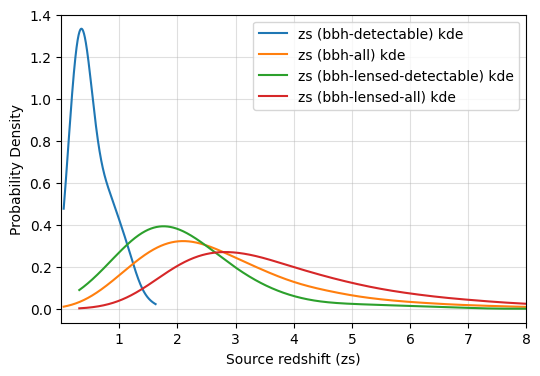

In [22]:
# quick plot
import matplotlib.pyplot as plt
from ler.utils import plots as lerplt

# plotting the distribution of event parameters
# comparision of redshift distribution for lensed and unlensed events
# param_dict can be either a dictionary or a json file name that contains the parameters
plt.figure(figsize=(6, 4))
# for unlensed case
lerplt.param_plot(
    param_name='zs',
    param_dict='ler_data/unlensed_param_detectable.json',
    plot_label='zs (bbh-detectable)',
    histogram=False,
    kde=True,
    kde_bandwidth=0.5,
)
lerplt.param_plot(
    param_name='zs',
    param_dict='ler_data/unlensed_param.json',
    plot_label='zs (bbh-all)',
    histogram=False,
    kde=True,
)
# for lensed case
lerplt.param_plot(
    param_name='zs',
    param_dict='ler_data/lensed_param_detectable.json',
    plot_label='zs (bbh-lensed-detectable)',
    histogram=False,
    kde=True,
    kde_bandwidth=0.5,
)
lerplt.param_plot(
    param_name='zs',
    param_dict='ler_data/lensed_param.json',
    plot_label='zs (bbh-lensed-all)',
    histogram=False,
    kde=True,
)
plt.xlim(0.001,8)
plt.grid(alpha=0.4)
plt.xlabel('Source redshift (zs)')
plt.ylabel('Probability Density')
plt.show()

## Using custom functions and parameters. <a class="anchor" id="bullet-two"></a>


* `ler` allows internal model functions to be change with custom functions.

* It also allows to change the default parameters of the existing model functions.

First let's look at what are the input parameters available for `LeR` class. The input paramters can divided into five categories

1. ler.LeR set up params

2. ler.CBCSourceParameterDistribution set up params (as kwargs)

3. ler.LensGalaxyParameterDistribution set up params (as kwargs)

4. ler.ImageProperties set up params (as kwargs)

5. gwsnr.GWSNR set up params (as kwargs)

Complete LeR initialization is shown below,

In [3]:
# # below is the example of LeR initialization with all the arguments.
from ler.rates import LeR
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM

# # Uncomment the below code if you need to change the default arguments.
# ler = LeR(
#     # LeR setup arguments
#     npool=4, # number of processors to use
#     z_min=0.0, # minimum redshift
#     z_max=10.0, # maximum redshift
#     event_type='BBH', # event type
#     size=100000, # number of events to simulate
#     batch_size=50000, # batch size
#     cosmology=LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
#     snr_finder=None, # snr calculator from 'gwsnr' package will be used
#     pdet_finder=None,  # will not be consider unless specified
#     list_of_detectors=None, # list of detectors that will be considered when calculating snr or pdet for lensed events. if None, all the detectors from 'gwsnr' will be considered
#     json_file_names=dict(
#         ler_params="ler_params.json", # to store initialization parameters and important results
#         unlensed_param="unlensed_param.json", # to store all unlensed events
#         unlensed_param_detectable="unlensed_param_detectable.json", # to store only detectable unlensed events
#         lensed_param="lensed_param.json", # to store all lensed events 
#         lensed_param_detectable="lensed_param_detectable.json"), # to store only detectable lensed events
#     interpolator_directory='./interpolator_json', # directory to store the interpolator pickle files. 'ler' uses interpolation to get values of various functions to speed up the calculations (relying on numba njit).
#     ler_directory='./ler_data', # directory to store all the outputs
#     verbose=False, # if True, will print all information at initialization

#     # CBCSourceParameterDistribution class arguments
#     source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 'source_frame_masses': 'binary_masses_BBH_popI_II_powerlaw_gaussian', 'zs': 'sample_source_redshift', 'geocent_time': 'sampler_uniform', 'ra': 'sampler_uniform', 'dec': 'sampler_cosine', 'phase': 'sampler_uniform', 'psi': 'sampler_uniform', 'theta_jn': 'sampler_sine'},
#     source_priors_params= {'merger_rate_density': {'R0': 2.39e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}, 'source_frame_masses': {'mminbh': 4.98, 'mmaxbh': 112.5, 'alpha': 3.78, 'mu_g': 32.27, 'sigma_g': 3.88, 'lambda_peak': 0.03, 'delta_m': 4.8, 'beta': 0.81}, 'zs': None, 'geocent_time': {'min_': 1238166018, 'max_': 1269702018}, 'ra': {'min_': 0.0, 'max_': 6.283185307179586}, 'dec': None, 'phase': {'min_': 0.0, 'max_': 6.283185307179586}, 'psi': {'min_': 0.0, 'max_': 3.141592653589793}, 'theta_jn': None},
#     spin_zero= True, # if True, spins will be set to zero
#     spin_precession= False, # if True, spins will be precessing

#     # LensGalaxyParameterDistribution class arguments
#     lens_type = 'epl_shear_galaxy',
#     lens_functions =  {'cross_section_based_sampler': 'rejection_sampling_with_cross_section_SIE', 'optical_depth': 'optical_depth_SIE_hemanta', 'param_sampler_type': 'sample_all_routine'},
#     lens_param_samplers =  {'source_redshift_sl': 'strongly_lensed_source_redshifts', 'lens_redshift': 'lens_redshift_SDSS_catalogue', 'velocity_dispersion': 'velocity_dispersion_ewoud', 'axis_ratio': 'axis_ratio_rayleigh', 'axis_rotation_angle': 'axis_rotation_angle_uniform', 'external_shear': 'shear_norm', 'density_profile_slope': 'density_profile_slope_normal', 'source_parameters': 'sample_gw_parameters'},
#     lens_param_samplers_params =  {'source_redshift_sl': None, 'lens_redshift': None, 'velocity_dispersion': None, 'axis_ratio': {'q_min': 0.2, 'q_max': 1.0}, 'axis_rotation_angle': {'phi_min': 0.0, 'phi_max': 6.283185307179586}, 'external_shear': {'scale': 0.05}, 'density_profile_slope': {'mean': 2.0, 'std': 0.2}, 'source_parameters': None},

#     # ImageProperties class arguments
#     n_min_images = 2,
#     n_max_images = 4,
#     geocent_time_min = 1126259462.4,
#     geocent_time_max = 1756979462.4,
#     lens_model_list = ['EPL_NUMBA', 'SHEAR'],

#     # gwsnr package arguments
#     mtot_min = 2.0,
#     mtot_max = 184.98599853446768,
#     ratio_min = 0.1,
#     ratio_max = 1.0,
#     mtot_resolution = 500,
#     ratio_resolution = 50,
#     sampling_frequency = 2048.0,
#     waveform_approximant = 'IMRPhenomD',
#     minimum_frequency = 20.0,
#     snr_type = 'interpolation',
#     psds = {'L1':'aLIGO_O4_high_asd.txt','H1':'aLIGO_O4_high_asd.txt', 'V1':'AdV_asd.txt', 'K1':'KAGRA_design_asd.txt'},
#     ifos = ['L1', 'H1', 'V1'],
#     interpolator_dir = './interpolator_json',
#     gwsnr_verbose = False,
#     multiprocessing_verbose = True,
#     mtot_cut = True,

#     # common arguments, to generate interpolator
#     create_new_interpolator = dict(
#         redshift_distribution=dict(create_new=False, resolution=1000),
#         z_to_luminosity_distance=dict(create_new=False, resolution=1000),
#         velocity_dispersion=dict(create_new=False, resolution=1000),
#         axis_ratio=dict(create_new=False, resolution=1000),
#         optical_depth=dict(create_new=False, resolution=200),
#         z_to_Dc=dict(create_new=False, resolution=1000),
#         Dc_to_z=dict(create_new=False, resolution=1000),
#         angular_diameter_distance=dict(create_new=False, resolution=1000),
#         differential_comoving_volume=dict(create_new=False, resolution=1000),
#         Dl_to_z=dict(create_new=False, resolution=1000),
#     )
# )

### Defining custom functions and parameters. <a class="anchor" id="bullet-two-one"></a>

As an example, I will change,

  * **merger_rate_density_params**'s default value of **local merger rate density** ($R_0$) to $38.8\times 10^{-9} Mpc^{-3} yr^{-1}$ (upper limit of GWTC-3). But, I am still using the default merger_rate_density function, which is `'merger_rate_density_bbh_popI_II_oguri2018'`. Note that the accepted $R_0$ value in [GWTC-3](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.13.011048) is $23.9_{-8.6}^{+14.9}\times 10^{-9} \; Mpc^{-3} yr^{-1}$.

  * **source_frame_masses** to a custom function. This is similar to the internal default function, i.e. `PowerLaw+Peak model`. I am using `gwcosmo`'s `powerlaw_gaussian` prior for this example.

  * **optical depth** for strong lensing condition and **velocity dispersion** of the lensing galaxy to SIS model and gamma function respectively. The default optical depth is that of the SIE model and default velocity dispersion has additional redshift dependence. Note the minimum and maximum values of the velocity dispersion. Default is $[10, 350] \; km/s$.
  
  * `gwsnr` parameters: By default, it uses **IMRPhenomD** **waveform model** with no spin. It uses interpolation method to find the 'snr' and it is super fast. But for the example below, I am using **IMRPhenomXPHM** with precessing spins. This is without interpolation but through inner product method, like that of `bilby` but with njit functions and multiprocessing. It will be slower as compare to interpolation method but faster than that of bilby.

**Note:** All custom functions sampler should have 'size' as the only input.

In [23]:
from gwcosmo import priors as p

# define your custom function of mass_1_source and mass_2_source calculation
# it should have 'size' as the only argument
def powerlaw_peak(size):
    """
    Function to sample mass1 and mass2 from a powerlaw with a gaussian peak

    Parameters
    ----------
    size : `int`
        Number of samples to draw

    Returns
    -------
    mass_1_source : `numpy.ndarray`
        Array of mass1 samples
    mass_2_source : `numpy.ndarray`
        Array of mass2 samples
    """


    # below is the gwcosmo default values
    mminbh=4.98  # Minimum mass of the black hole (Msun)
    mmaxbh=86.22  # Maximum mass of the black hole (Msun) 
    alpha=2.63  # Spectral index for the powerlaw of the primary mass distribution
    mu_g=33.07  # Mean of the Gaussian component in the primary mass distribution
    sigma_g=5.69  # Width of the Gaussian component in the primary mass distribution
    lambda_peak=0.10  # Fraction of the model in the Gaussian component
    delta_m=4.82  # Range of mass tapering on the lower end of the mass distribution
    beta=1.26  # Spectral index for the powerlaw of the mass ratio distribution

    model = p.BBH_powerlaw_gaussian(
        mminbh=mminbh,
        mmaxbh=mmaxbh,
        alpha=alpha,
        mu_g=mu_g,
        sigma_g=sigma_g,
        lambda_peak=lambda_peak,
        delta_m=delta_m,
        beta=beta,
    )
    # sample mass1 and mass2
    mass_1_source, mass_2_source = model.sample(Nsample=size)

    return (mass_1_source, mass_2_source)

### LeR initialization with custom functions and parameters <a class="anchor" id="bullet-two-two"></a>

* Initialize the class with the custom function

* changing ler input params

In [24]:
from ler.rates import LeR
import numpy as np

ler = LeR(npool=4, verbose=False,
    # for source parameters  
    source_priors=dict(
        merger_rate_density='merger_rate_density_bbh_popI_II_oguri2018',
        source_frame_masses=powerlaw_peak,
    ),
    source_priors_params=dict(
        merger_rate_density=dict(
            R0=38.8e-09,
            b2=1.6,
            b3=2.0,
            b4=30
        ),
        source_frame_masses=None,
    ),
    # for lens parameters
    lens_functions=dict(
        cross_section_based_sampler="rejection_sampling_with_cross_section_SIS",
        optical_depth="optical_depth_SIS_haris",
    ),
    lens_param_samplers=dict(
        velocity_dispersion="velocity_dispersion_gengamma",
    ),
    lens_param_samplers_params=dict(
        velocity_dispersion=dict(a=2.32 / 2.67, c=2.67)
    ),
    # for snr generation
    waveform_approximant = 'IMRPhenomXPHM',
    snr_type='inner_product',
    spin_zero=False,
    spin_precession=True,
)

* since I am using inner product to calculate snr, it will take longer time to simulate the events.

* You can increase the speed by allocating more CPU cores to the code. For example, if you have 8 logical cores, set npool>4

### Sampling (Unlensed). <a class="anchor" id="bullet-two-three"></a>

In [25]:
ler.batch_size = 25000
# increase size for accurate rate calculation
# for Apple silicon M2 pro 16GB RAM, npool=4, time taken is 1m 44.8s
ler.unlensed_cbc_statistics(size=50000, resume=False, output_jsonfile = 'new_unlensed_params.json');

unlensed params will be store in ./ler_data/new_unlensed_params.json
chosen batch size = 25000 with total size = 50000
There will be 2 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|████████████████████████████████████████████████████████| 20250/20250 [00:51<00:00, 396.70it/s]

Batch no. 2
sampling gw source params...
calculating snrs...
solving SNR with inner product



100%|████████████████████████████████████████████████████████| 20344/20344 [00:51<00:00, 391.53it/s]


saving all unlensed parameters in ./ler_data/new_unlensed_params.json 


### Sampling (Lensed). <a class="anchor" id="bullet-two-four"></a>

In [26]:
# increase the size if you need accurate rate calculation
# for Apple silicon M2 pro 16GB RAM, npool=4, time taken is 
ler.lensed_cbc_statistics(size=50000, resume=False, output_jsonfile = 'new_lensed_params.json');

lensed params will be store in ./ler_data/new_lensed_params.json
chosen batch size = 25000 with total size = 50000
There will be 2 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:06<00:00, 3965.92it/s]


Invalid sample found. Resampling 1 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]

calculating snrs...
solving SNR with inner product



100%|████████████████████████████████████████████████████████| 18026/18026 [00:46<00:00, 391.77it/s]


solving SNR with inner product


100%|████████████████████████████████████████████████████████| 18026/18026 [00:43<00:00, 410.05it/s]


solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 2600/2600 [00:06<00:00, 410.74it/s]

solving SNR with inner product



100%|██████████████████████████████████████████████████████████| 2201/2201 [00:05<00:00, 405.64it/s]


Batch no. 2
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4262.94it/s]


Invalid sample found. Resampling 2 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.85it/s]

calculating snrs...
solving SNR with inner product



100%|████████████████████████████████████████████████████████| 18070/18070 [00:43<00:00, 412.07it/s]


solving SNR with inner product


100%|████████████████████████████████████████████████████████| 18070/18070 [00:44<00:00, 409.45it/s]


solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 2566/2566 [00:06<00:00, 414.08it/s]

solving SNR with inner product



100%|██████████████████████████████████████████████████████████| 2184/2184 [00:05<00:00, 413.02it/s]


saving all lensed parameters in ./ler_data/new_lensed_params.json 


* generate detectable events and compute the rate ratio

* note: here no input params are provided, so it will track the json files generated above

* For individual rate computation, use
    ```ler.unlensed_rate();```
    ```ler.lensed_rate();```

### Rate calculation and comparison. <a class="anchor" id="bullet-two-five"></a>

In [28]:
# you might not need to provide the json file names
# at the end of each sampling, the json file names will be updated in the ler_params.json file. The default json file names are call from the ler_params.json file.
rate_ratio, unlensed_param_detectable, lensed_param_detectable =ler.rate_comparison_with_rate_calculation(
    unlensed_param='new_unlensed_params.json',
    snr_threshold_unlensed=8.0,
    lensed_param='new_lensed_params.json',
    output_jsonfile_unlensed='new_unlensed_params_detectable.json',
    output_jsonfile_lensed='new_lensed_params_detectable.json',
    snr_threshold_lensed=[8.0,8.0],
    num_img=[1,1],
)

Getting unlensed_param from json file ./ler_data/new_unlensed_params.json...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1): 1522.6442174796687
number of simulated unlensed detectable events: 453
number of simulated all unlensed events: 50000
storing detectable params in ./ler_data/new_unlensed_params_detectable.json
Getting lensed_param from json file ./ler_data/new_lensed_params.json...
given detectability_condition == step_function
total lensed rate (yr^-1): 1.1059902347300807
number of simulated lensed detectable events: 337
number of simulated all lensed events: 50000
storing detectable params in ./ler_data/new_lensed_params_detectable.json
unlensed_rate: 1522.6442174796687
lensed_rate: 1.1059902347300807
ratio: 1376.7248296286027


**Important Note:**
* input parameters, snr_threshold_lensed=[8.0,8.0], num_img=[1,1], means that two of the images should have snr>8.0. You can also set: snr_threshold_lensed=8, num_img=2

* Similarly, if snr_threshold_lensed=[8.0,6.0], num_img=[2,2], it means that two of the images should have snr>8.0 and other two images should have snr>6.0. But in this case, even though the simulated lensed (detectable) events are correct, the rate calculation will not be right as the strong lensing condition was set for 2 image case.

## Uning available model functions <a class="anchor" id="bullet-three"></a>

How to look for available model functions?

* All available names are stored as a dict in `ler` instance

* the keys of this dict shows the parameter type

* the values are also dict, where the keys are the model function names and the values are their input parameters

In [29]:
# for unlensed case
print(ler.available_gw_prior_list_and_its_params['source_frame_masses'])
# for lensed case
print(ler.available_lens_prior_list_and_its_params['velocity_dispersion'])

{'binary_masses_BBH_popI_II_powerlaw_gaussian': {'mminbh': 4.98, 'mmaxbh': 112.5, 'alpha': 3.78, 'mu_g': 32.27, 'sigma_g': 3.88, 'lambda_peak': 0.03, 'delta_m': 4.8, 'beta': 0.81}, 'binary_masses_BBH_popIII_lognormal': {'Mc': 30.0, 'sigma': 0.3, 'beta': 1.1}, 'binary_masses_BBH_primordial_lognormal': {'Mc': 30.0, 'sigma': 0.3, 'beta': 1.1}, 'binary_masses_BNS_gwcosmo': {'mminns': 1.0, 'mmaxns': 3.0, 'alphans': 0.0}, 'binary_masses_BNS_bimodal': {'w': 0.643, 'muL': 1.352, 'sigmaL': 0.08, 'muR': 1.88, 'sigmaR': 0.3, 'mmin': 1.0, 'mmax': 2.3}}
{'velocity_dispersion_haris': {'a': 0.8689138576779026, 'c': 2.67}, 'velocity_dispersion_gengamma': {'a': 0.8689138576779026, 'c': 2.67}, 'velocity_dispersion_bernardi': None, 'velocity_dispersion_ewoud': None}


* for looking at the choosen models and its input parameters

In [30]:
# for unlensed case
print(ler.gw_param_samplers)
print(ler.gw_param_samplers_params)
# for lensed case
print(ler.lens_param_samplers)
print(ler.lens_param_samplers_params)

{'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 'source_frame_masses': <function powerlaw_peak at 0x32f3ffd90>, 'zs': 'sample_source_redshift', 'geocent_time': 'sampler_uniform', 'ra': 'sampler_uniform', 'dec': 'sampler_cosine', 'phase': 'sampler_uniform', 'psi': 'sampler_uniform', 'theta_jn': 'sampler_sine', 'a_1': 'sampler_uniform', 'a_2': 'sampler_uniform', 'tilt_1': 'sampler_sine', 'tilt_2': 'sampler_sine', 'phi_12': 'sampler_uniform', 'phi_jl': 'sampler_uniform'}
{'merger_rate_density': {'R0': 3.88e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}, 'source_frame_masses': None, 'zs': None, 'geocent_time': {'min_': 1238166018, 'max_': 1269702018}, 'ra': {'min_': 0.0, 'max_': 6.283185307179586}, 'dec': None, 'phase': {'min_': 0.0, 'max_': 6.283185307179586}, 'psi': {'min_': 0.0, 'max_': 3.141592653589793}, 'theta_jn': None, 'a_1': {'min_': 0.0, 'max_': 0.8}, 'a_2': {'min_': 0.0, 'max_': 0.8}, 'tilt_1': None, 'tilt_2': None, 'phi_12': {'min_': 0, 'max_': 6.283185307179586}, 'p

### Comparison of mass distribution model (BBH, mass-1, larger mass only). <a class="anchor" id="bullet-three-one"></a>

* compare the default mass distribution with the custom mass distribution function defined on the previous example [link](###bullet-two-one). 

In [31]:
# calling the default mass distribution model
mass_1_source, mass_2_source = ler.binary_masses_BBH_popI_II_powerlaw_gaussian(size=10000)
default_model_dict = dict(mass_1_source=mass_1_source)

# calling the custom mass distribution model
mass_1_source, mass_2_source = powerlaw_peak(size=10000)
custom_model_dict = dict(mass_1_source=mass_1_source)

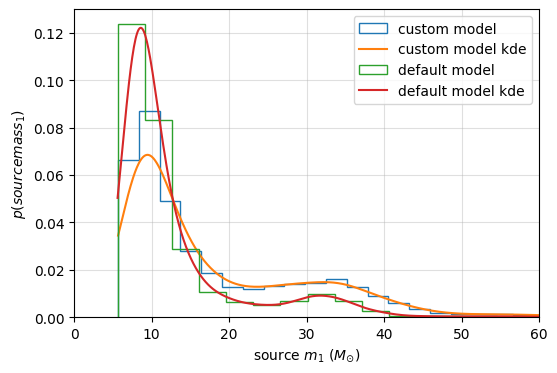

In [32]:
import matplotlib.pyplot as plt
from ler.utils import plots as lerplt

# let's do a comparision plot between you custom model and the default model
plt.figure(figsize=(6, 4))
lerplt.param_plot(
    param_name="mass_1_source", 
    param_dict=custom_model_dict, # or the json file name
    plot_label='custom model',
);
lerplt.param_plot(
    param_name="mass_1_source", 
    param_dict=default_model_dict,
    plot_label='default model',
);
plt.xlabel(r'source $m_1$ ($M_{\odot}$)')
plt.ylabel(r'$p(source mass_1)$')
plt.xlim(0,60)
plt.grid(alpha=0.4)
plt.show()

### Comparison of Axis-ratio model of the lensing galaxy. <a class="anchor" id="bullet-three-two"></a>

* compare the default axis-ratio distribution (gengamma, from SDSS galaxy catalogue, Haris et al. 2018) with axis-ratio distribution from Padilla and Strauss 2008 

In [28]:
size = 10000
padilla_strauss = ler.axis_ratio_padilla_strauss(size=size)

# axis_ratio_rayleigh depends on the velocity dispersion
sigma = ler.velocity_dispersion_gengamma(size=size)
rayleigh = ler.axis_ratio_rayleigh(sigma=sigma)

# make a dict
axis_ratio_dict = dict(
    padilla_strauss=padilla_strauss,
    rayleigh=rayleigh,
)

axis_ratio_spline_coeff interpolator will be generated at ./interpolator_json/axis_ratio/axis_ratio_spline_coeff_0.pickle
axis_ratio interpolator will be generated at ./interpolator_json/axis_ratio/axis_ratio_1.pickle


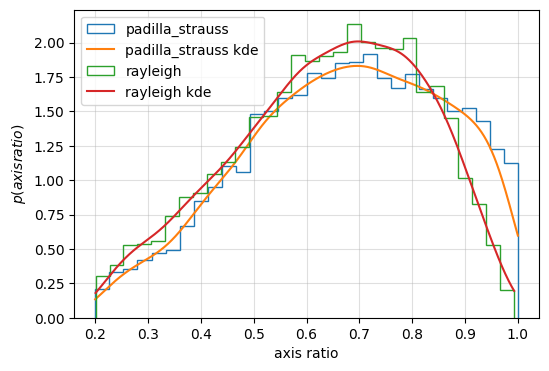

In [29]:
# plot the distribution of axis-ratio
plt.figure(figsize=(6, 4))
lerplt.param_plot(
    param_name="padilla_strauss",
    param_dict=axis_ratio_dict,
    plot_label='padilla_strauss',
)
lerplt.param_plot(
    param_name="rayleigh",
    param_dict=axis_ratio_dict,
    plot_label='rayleigh',
)
plt.xlabel(r'axis ratio')
plt.ylabel(r'$p(axis ratio)$')
plt.grid(alpha=0.4)
plt.show()

## Generating particular number of detectable events. <a class="anchor" id="bullet-four"></a>

* this is particularly useful when you want only the detectable events to be saved in the json file

* detectable event rates will be calculated at each batches. Subsequent batch will consider the previous batch's detectable events. So, the rates will become more accurate as the batch number increases and will converge to a stable value at higher samples. 

* you can resume the rate calculation from the last saved batch.

In [33]:
from ler.rates import LeR

# class initialization
ler = LeR(npool=8, verbose=False)

### Unlensed case. <a class="anchor" id="bullet-four-one"></a>

* SNR>8

In [34]:
n_size_unlensed_param = ler.selecting_n_unlensed_detectable_events(
    size=5000, 
    snr_threshold=10.0,
    batch_size=100000,
    resume=False,
    output_jsonfile='unlensed_params_n_detectable.json',
    meta_data_file="meta_unlensed.json",
    )

removing ./ler_data/unlensed_params_n_detectable.json and ./ler_data/meta_unlensed.json if they exist
collected number of detectable events =  0
given detectability_condition == 'step_function'
collected number of detectable events =  422
total number of events =  100000
total rate (yr^-1): 436.86662367311965
given detectability_condition == 'step_function'
collected number of detectable events =  841
total number of events =  200000
total rate (yr^-1): 435.31378022404454
given detectability_condition == 'step_function'
collected number of detectable events =  1255
total number of events =  300000
total rate (yr^-1): 433.0707841309361
given detectability_condition == 'step_function'
collected number of detectable events =  1705
total number of events =  400000
total rate (yr^-1): 441.2663467788323
given detectability_condition == 'step_function'
collected number of detectable events =  2094
total number of events =  500000
total rate (yr^-1): 433.5538909817594
given detectability_condi

**Important Note**: At each iteration, rate is calculated using the cummulatively increasing number of events. It will become stable at around 2 million events. This is the number of events that is required to get a stable rate. Below, I am showing visualization of how rate changes with increasing number of events.

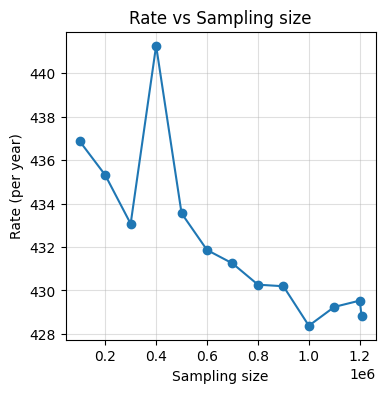

In [35]:
from ler.utils import get_param_from_json
# getting data from json
meta_data= get_param_from_json("./ler_data/meta_unlensed.json")

# plot the rate vs sampling size
plt.figure(figsize=(4,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

### Lensed case. <a class="anchor" id="bullet-four-two"></a>

* 2 images, snr>8 (super-threshold)
* 1 image, snr>6 (sub+super-threshold)

In [36]:
n_size_lensed_param = ler.selecting_n_lensed_detectable_events(
    size=500,
    snr_threshold=[8.0,6.0],
    num_img=[2,1],
    batch_size=50000,
    resume=False,
    output_jsonfile='lensed_params_n_detectable.json',
    meta_data_file="meta_lensed.json",
    )

removing ./ler_data/lensed_params_n_detectable.json and ./ler_data/meta_lensed.json if they exist
collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


given detectability_condition == step_function
collected number of detectable events =  112
total number of events =  50000
total rate (yr^-1): 0.508493641457471


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.66it/s]


given detectability_condition == step_function
collected number of detectable events =  212
total number of events =  100000
total rate (yr^-1): 0.48125291066510645


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 38.02it/s]


given detectability_condition == step_function
collected number of detectable events =  317
total number of events =  150000
total rate (yr^-1): 0.4797395367321973


100%|███████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4289.40it/s]


given detectability_condition == step_function
collected number of detectable events =  433
total number of events =  200000
total rate (yr^-1): 0.4914681847122432


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.09it/s]


given detectability_condition == step_function
collected number of detectable events =  531
total number of events =  250000
total rate (yr^-1): 0.48216093502485197
storing detectable lensed params in ./ler_data/lensed_params_n_detectable.json
storing meta data in ./ler_data/meta_lensed.json

 trmming final result to size=500
collected number of detectable events =  500
total number of events =  235405.0
total lensed event rate (yr^-1): 0.4821607228741339


In [37]:
print(n_size_lensed_param.keys())
print(f"size of each parameters={len(n_size_lensed_param['zl'])}")

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'snr_net', 'L1', 'H1', 'V1'])
size of each parameters=500


## Using custom detection criteria. <a class="anchor" id="bullet-five"></a>

* I leverage the ANN (Artificial Neural Network) based SNR calculator from gwsnr. It can predict SNR>8 with 99.9% accuracy for the astrophysical parameters. But to make it 100% accurate, I will recalculate SNR some of the events using inner product method. LeR can do this automatically. 

* I will test two cases using: 
  * pdet (probability of detection) with ANN
  * SNR with ANN.

* **Note:** Check out [GRB rate calculation example](https://ler.readthedocs.io/en/latest/examples/rates/grb%20detection%20rate.html) for more details on how to use custom detection criteria.

In [38]:
from ler.rates import LeR
from gwsnr import GWSNR
import numpy as np

### Defining custom detection criteria (using `gwsnr` package). <a class="anchor" id="bullet-five-one"></a>

* pdet only calculation

In [39]:
snr_ = GWSNR(gwsnr_verbose=True, pdet=True, snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
Interpolator will be loaded for L1 detector from ./interpolator_json/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_json/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_json/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.

### Testing the custom detection criteria. <a class="anchor" id="bullet-five-two"></a>

* Pdet calculator test

In [40]:
# initialization pdet calculator
pdet_calculator = snr_.snr
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
luminosity_distance = np.array([1000, 2000, 3000, 4000])
# test
pdet = pdet_calculator(
    gw_param_dict=dict(
        mass_1=mass_1,
        mass_2=mass_1*ratio,
        luminosity_distance=luminosity_distance,
    )
)
inner_product_snr = snr_.compute_bilby_snr(
    mass_1=mass_1,
    mass_2=mass_1*ratio,
    luminosity_distance=luminosity_distance,
)

print(f"pdet: {pdet}")
print(f"inner_product_snr: {inner_product_snr}")

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.74it/s]

pdet: {'L1': array([0, 0, 1, 0]), 'H1': array([0, 0, 0, 0]), 'V1': array([0, 0, 0, 0]), 'pdet_net': array([1, 0, 1, 0])}
inner_product_snr: {'L1': array([ 7.4441411 ,  5.85368864, 10.6450267 ,  0.        ]), 'H1': array([4.73471203, 3.72313335, 6.77057773, 0.        ]), 'V1': array([2.23257635, 1.73563894, 3.21070705, 0.        ]), 'snr_net': array([ 9.10039185,  7.15121214, 13.01790904,  0.        ])}


### Using custom detection criteria with LeR. <a class="anchor" id="bullet-five-three"></a>

* Below is an example of general case of initialising with any type of pdet calculator.

* Refer to the [documentation](https://ler.readthedocs.io/en/latest/examples/rates/grb%20detection%20rate.html) example for extra details, where I have used pdet for GRB (gamma-ray-burst) detection.

In [41]:
from ler.rates import LeR

ler = LeR(verbose=False, pdet_finder=pdet_calculator, spin_zero=False,
    spin_precession=True)

In [42]:
unlensed_param = ler.unlensed_cbc_statistics();

unlensed params will be store in ./ler_data/unlensed_param.json
chosen batch size = 50000 with total size = 100000
There will be 2 batche(s)
Batch no. 1
sampling gw source params...
calculating pdet...
Batch no. 2
sampling gw source params...
calculating pdet...
saving all unlensed parameters in ./ler_data/unlensed_param.json 


* now calculate rate using the custom 'pdet' calculator

In [43]:
_, unlensed_param_detectable = ler.unlensed_rate(detectability_condition='pdet')

Getting unlensed_param from json file ./ler_data/unlensed_param.json...
given detectability_condition == 'pdet'
total unlensed rate (yr^-1): 502.08604853427255
number of simulated unlensed detectable events: 485
number of simulated all unlensed events: 100000
storing detectable params in ./ler_data/unlensed_param_detectable.json


In [44]:
# # for lensed case
# lensed_param = ler.lensed_cbc_statistics()
# _, lensed_param_detectable = ler.lensed_rate(detectability_condition='pdet')

### Analysis: SNR (with ANN) + SNR recalculation (inner product). <a class="anchor" id="bullet-five-four"></a>

In [45]:
from ler.rates import LeR

# ler initialization with gwsnr arguments
ler = LeR(npool=6, 
    verbose=False, 
    snr_type='ann', 
    waveform_approximant='IMRPhenomXPHM', 
    spin_zero=False,
    spin_precession=True
)

In [46]:
unlensed_param = ler.selecting_n_unlensed_detectable_events(
    size=500, 
    snr_threshold=10.0,
    batch_size=50000,
    resume=False,
    trim_to_size=False,
    output_jsonfile='unlensed_params_n_detectable_ann.json',
    meta_data_file="meta_unlensed_ann.json",
    snr_recalculation=True,
    snr_threshold_recalculation=[4,20], # it will recalculate SNR for events with (SNR_ANN > 4) and (SNR_ANN < 20)
    )

removing ./ler_data/unlensed_params_n_detectable_ann.json and ./ler_data/meta_unlensed_ann.json if they exist
collected number of detectable events =  0


100%|██████████████████████████████████████████████████████████| 1598/1598 [00:04<00:00, 351.02it/s]


given detectability_condition == 'step_function'
collected number of detectable events =  204
total number of events =  50000
total rate (yr^-1): 422.373418148419


100%|██████████████████████████████████████████████████████████| 1557/1557 [00:04<00:00, 344.99it/s]


given detectability_condition == 'step_function'
collected number of detectable events =  425
total number of events =  100000
total rate (yr^-1): 439.97231057126976


100%|██████████████████████████████████████████████████████████| 1503/1503 [00:04<00:00, 345.51it/s]

given detectability_condition == 'step_function'
collected number of detectable events =  604
total number of events =  150000
total rate (yr^-1): 416.85219699615203
stored detectable unlensed params in ./ler_data/unlensed_params_n_detectable_ann.json
stored meta data in ./ler_data/meta_unlensed_ann.json


In [47]:
# # Uncomment the below code if you need to compare with the rate calculation using inner product snr

from ler.rates import LeR

# # ler initialization with gwsnr arguments
# ler = LeR(npool=6, verbose=False, snr_type='inner_product', waveform_approximant='IMRPhenomXPHM', spin_zero=False,
#     spin_precession=True)

# unlensed_param = ler.selecting_n_unlensed_detectable_events(
#     size=1000, 
#     snr_threshold=10.0,
#     batch_size=50000,
#     resume=False,
#     output_jsonfile='unlensed_params_n_detectable.json',
#     meta_data_file="meta_unlensed.json",
#     )

In [48]:
lensed_param = ler.selecting_n_lensed_detectable_events(
    size=500,
    snr_threshold=[8.0,8.0],
    num_img=[1,1],
    batch_size=50000,
    resume=False,
    output_jsonfile='lensed_params_n_detectable_ann.json',
    meta_data_file="meta_lensed_ann.json",
    snr_recalculation=True,
    snr_threshold_recalculation=[[4,4], [20,20]], # it will recalculate SNR for events with (SNR_ANN > 4) and (SNR_ANN < 20)
)

removing ./ler_data/lensed_params_n_detectable_ann.json and ./ler_data/meta_lensed_ann.json if they exist
collected number of detectable events =  0


100%|███████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4310.16it/s]


calculating snrs...


100%|████████████████████████████████████████████████████████████| 964/964 [00:02<00:00, 377.48it/s]


given detectability_condition == step_function
collected number of detectable events =  220
total number of events =  50000
total rate (yr^-1): 0.9988267957200324


100%|███████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4299.16it/s]


calculating snrs...


100%|████████████████████████████████████████████████████████████| 884/884 [00:02<00:00, 375.81it/s]


given detectability_condition == step_function
collected number of detectable events =  430
total number of events =  100000
total rate (yr^-1): 0.9761261867263953


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.26it/s]


calculating snrs...


100%|████████████████████████████████████████████████████████████| 919/919 [00:02<00:00, 379.79it/s]


given detectability_condition == step_function
collected number of detectable events =  662
total number of events =  150000
total rate (yr^-1): 1.0018535435858507
storing detectable lensed params in ./ler_data/lensed_params_n_detectable_ann.json
storing meta data in ./ler_data/meta_lensed_ann.json

 trmming final result to size=500
collected number of detectable events =  500
total number of events =  113293.0
total lensed event rate (yr^-1): 1.001853997759663


In [49]:
ler.rate_ratio();

unlensed_rate: 416.85219699615203
lensed_rate: 1.001853997759663
ratio: 416.0807841544908
